# Week 5 — Predict2Optimize

This week is about **putting everything together**.

You will run a portfolio *over time* by combining: prediction, optimization, and backtesting.

There is no single correct solution here! Still some pointers are given.

---

## The loop

> predict returns → optimize portfolio → hold → rebalance → repeat

---

## What you need to do (roughly)

1. **Choose assets and dates**  
   Use a small set of tickers and a reasonable time range.

2. **Build a predictor**  
   Estimate $\hat\mu_t, \hat\Sigma_t$ using past returns only.

   Stick to an easy model - linear predictor for returns, and simple rolling covariance estimate for covariance matrix.

3. **Set a baseline**  
   Examples: 1/N portfolio, or GMVP etc.

4. **Reuse your optimizer**  
   Use your Week 4 Markowitz optimizer.

5. **Write a strategy function**  
   Takes time `t`, past returns, previous weights -> returns new weights. See the howto.

6. **Run the backtest**  
   Choose rebalancing frequency and transaction costs.

7. **Plot diagnostics**
    * Net wealth
    * Daily returns
    * Portfolio weights
    * Turnover
    * ... feel free to extend this, perhaps track the free cash as well?

    > Compare against your baseline.

---

## Common pitfalls

* **Look-ahead bias**
* **Too-frequent rebalancing**
* **Overtrusting predictions**
    - assume some simple uncertainty set and use robust optimization!

---

## Bonus ideas (optional)

* Transaction-cost-aware optimizer (see last bonus section in [howto.ipynb](howto.ipynb))
* Weekly vs monthly rebalancing
* Robust Markowitz
* Rolling Sharpe ratio

---

That’s it. Build a portfolio using the tools you wrote (and the helpers :D)!

Optimize away!
---

In [1]:
# TODO: See the code in howto.ipynb for skeleton/boilerplate structure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp

from backtesting_utils import (
    load_return_data,
    plot_wealth,
    plot_returns,
    plot_weights_over_time,
    plot_weights_stacked_area,
    plot_turnover,
    print_performance_summary
)

from helpers import (
    save_predictions,
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
    visualize_single_portfolio,
)

sns.set_theme(style="darkgrid")


In [2]:
def run_backtest(
    returns,
    dates,
    initial_wealth,
    strategy_fn,
    lookback=60,
    rebalance_period=21,
    transaction_cost_factor=0.0,
):
    returns = np.asarray(returns)
    T, n = returns.shape

    wealth = np.zeros(T)
    port_returns = np.zeros(T)
    turnover = np.zeros(T)
    weights_hist = np.zeros((T, n))

    wealth[0] = initial_wealth
    weights = np.ones(n) / n   # start invested

    # ----------------------------
    # Warm-up period (NO strategy)
    # ----------------------------
    for t in range(lookback):
        port_ret = weights @ returns[t]
        port_returns[t] = port_ret
        wealth[t+1] = wealth[t] * (1 + port_ret)
        weights_hist[t+1] = weights

    # ----------------------------
    # Main backtest
    # ----------------------------
    for t in range(lookback, T - 1):

        if t % rebalance_period == 0:
            target_weights = strategy_fn(t, returns, weights)
            trade = np.abs(target_weights - weights).sum()
            cost = transaction_cost_factor * trade
            wealth[t] *= (1 - cost)
            weights = target_weights
            turnover[t] = trade

        port_ret = weights @ returns[t + 1]
        port_returns[t + 1] = port_ret
        wealth[t + 1] = wealth[t] * (1 + port_ret)
        weights_hist[t + 1] = weights

    return {
        "wealth": wealth,
        "returns": port_returns,
        "weights": weights_hist,
        "turnover": turnover,
        "dates": dates,
    }

In [3]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]

returns_df = load_return_data(
    tickers,
    start="2017-01-01",
    end="2017-12-31",
)

display(returns_df.head()) # shape: (T, n_assets)

returns = returns_df.values
dates = returns_df.index.astype(str).tolist()
tickers = list(returns_df.columns)

n_assets = len(tickers)

Ticker,AAPL,MSFT,AMZN,GOOG,TLT
Date,,,,,
2017-01-04,-0.001119,-0.004474,0.004657,0.000967,0.003845
2017-01-05,0.005085,0.000000,0.030732,0.009048,0.015654
2017-01-06,0.011148,0.008668,0.019912,0.015277,-0.009182
2017-01-09,0.009160,-0.003183,0.001168,0.000620,0.008026
2017-01-10,0.001009,-0.000319,-0.001280,-0.002306,-0.000657


In [4]:
# sample predictor, this is where week 2 and ~3~ will come in handy
# ! unused here
def predict_mu_sigma(returns_window):
    mu_hat = returns_window.mean(axis=0)
    Sigma_hat = np.cov(returns_window, rowvar=False)
    return mu_hat, Sigma_hat

In [5]:
# SIMPLE STRATEGY
# equal weights with some noise based on time
def equal_weight_strategy(t, returns, current_weights, lookback=60):
    np.random.seed(t)
    # returns, lookback unused
    w_opt = current_weights + np.abs(np.random.randn(*current_weights.shape)) * 0.01
    w_opt = w_opt / (w_opt.sum())
    return w_opt

In [6]:
def markowitz_portfolio(mu, Sigma, lam, gamma=2.0, u=1.0):
    import cvxpy as cp
    import numpy as np

    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    n = len(mu)

    w = cp.Variable(n)

    objective = cp.Maximize(
        mu @ w - lam * cp.quad_form(w, Sigma)
    )

    constraints = [
        cp.sum(w) == 1,          # fully invested
        w >= 0,                  # long-only
        cp.norm1(w) <= gamma,    # leverage limit
        w <= u                   # max position size
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    if w.value is None:
        raise ValueError("Markowitz optimization failed")

    return w.value

In [7]:
def markowitz_strategy(
    t,
    returns,
    current_weights,
    lookback=60,
    lam=1.0,
    gamma=2.0,
    u=1.0,
):
    # Not enough data → fallback
    if t < lookback:
        n = returns.shape[1]
        return np.ones(n) / n

    # 1. Past data only (NO look-ahead)
    window = returns[t - lookback : t]

    # 2. Predict
    mu_hat = window.mean(axis=0)
    Sigma_hat = np.cov(window, rowvar=False)

    # Numerical stability
    Sigma_hat += 1e-6 * np.eye(len(mu_hat))

    # 3. Optimize (Week 4 solver)
    w_opt = markowitz_portfolio(
        mu_hat,
        Sigma_hat,
        lam=lam,
        gamma=gamma,
        u=u,
    )

    return w_opt

In [8]:
def robust_markowitz_strategy(
    t,
    returns,
    current_weights,
    lookback=60,
    lam=1.0,
    eps=0.05,
):
    if t < lookback:
        n = returns.shape[1]
        return np.ones(n) / n

    window = returns[t - lookback : t]

    mu_hat = window.mean(axis=0)
    Sigma_hat = np.cov(window, rowvar=False)
    Sigma_hat += 1e-6 * np.eye(len(mu_hat))

    w_opt = robust_markowitz(
        mu_hat,
        Sigma_hat,
        lam=lam,
        eps=eps,
    )

    return w_opt

In [9]:
results = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: equal_weight_strategy(t, r, w),
    lookback=10,  # dummy
    rebalance_period=21,
    transaction_cost_factor=0.001,
)

In [10]:
results_markowitz = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: markowitz_strategy(
        t, r, w,
        lookback=60,
        lam=1.2,
        gamma=2.0,
        u=0.9,
    ),
    lookback=60,
    rebalance_period=21,
    transaction_cost_factor=0.001,
)

In [11]:
def robust_markowitz(mu, Sigma, lam, eps):
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    n = len(mu)

    w = cp.Variable(n)

    objective = cp.Maximize(
        mu @ w
        - eps * cp.norm(w, 2)
        - lam * cp.quad_form(w, Sigma)
    )

    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    if w.value is None:
        raise ValueError("Robust Markowitz optimization failed")

    return w.value

In [12]:
results_robust = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: robust_markowitz_strategy(
        t, r, w,
        lookback=60,
        lam=1.2,
        eps=0.05,
    ),
    lookback=60,
    rebalance_period=21,
    transaction_cost_factor=0.001,
)

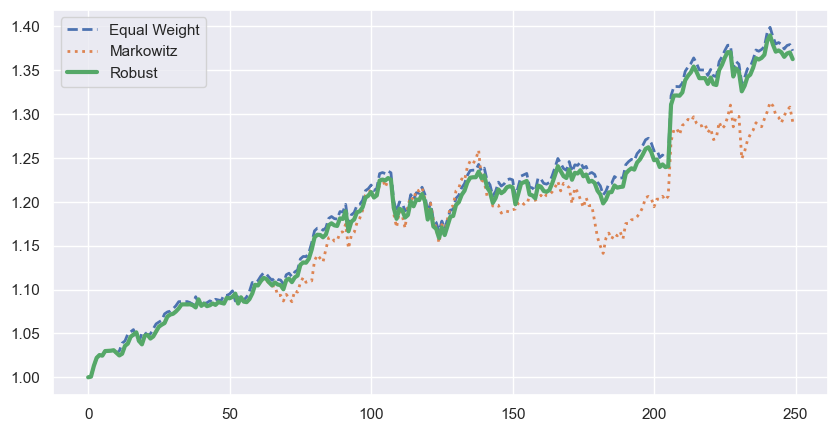

In [13]:
plt.figure(figsize=(10,5))
plt.plot(results["wealth"], "--", label="Equal Weight", linewidth=2)
plt.plot(results_markowitz["wealth"], ":", label="Markowitz", linewidth=2)
plt.plot(results_robust["wealth"], "-", label="Robust", linewidth=3)

plt.legend()
plt.grid(True)
plt.show()

In [14]:
assert results is not results_markowitz
assert results_markowitz is not results_robust

In [15]:
print("=== Equal Weight ===")
print_performance_summary(results["wealth"], results["returns"])

print("\n=== Markowitz / GMV ===")
print_performance_summary(results_markowitz["wealth"], results_markowitz["returns"])
print("\n=== Robust ===")
print_performance_summary(results_robust["wealth"], results_robust["returns"])

=== Equal Weight ===
Performance summary
-------------------
Total return:     37.23%
Avg daily return: 0.0013
Daily volatility: 0.0070

=== Markowitz / GMV ===
Performance summary
-------------------
Total return:     29.13%
Avg daily return: 0.0011
Daily volatility: 0.0086

=== Robust ===
Performance summary
-------------------
Total return:     36.28%
Avg daily return: 0.0013
Daily volatility: 0.0071


In [16]:
lookback = 60

mu_hat = returns[-lookback:].mean(axis=0)
Sigma_hat = np.cov(returns[-lookback:], rowvar=False)

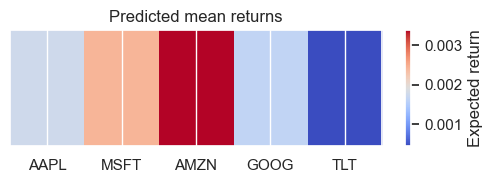

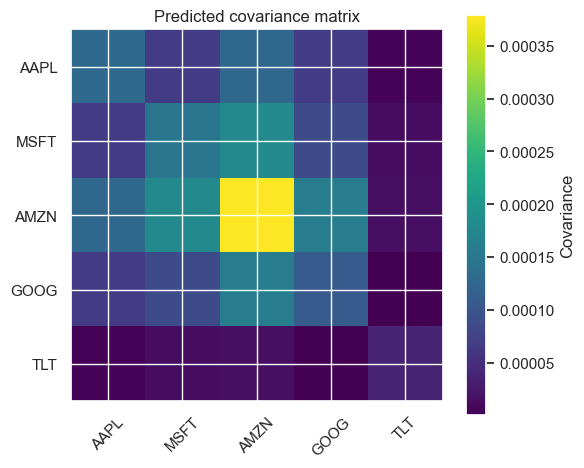

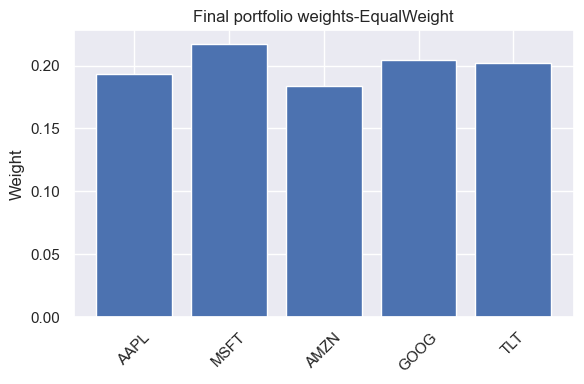

Final portfolio statistics
---------------------------
Expected return : 0.0019
Volatility      : 0.0093
Sharpe ratio    : 0.2048


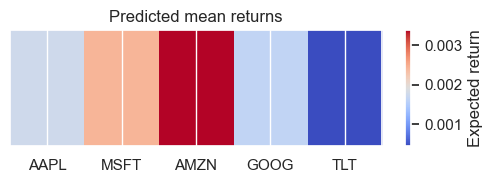

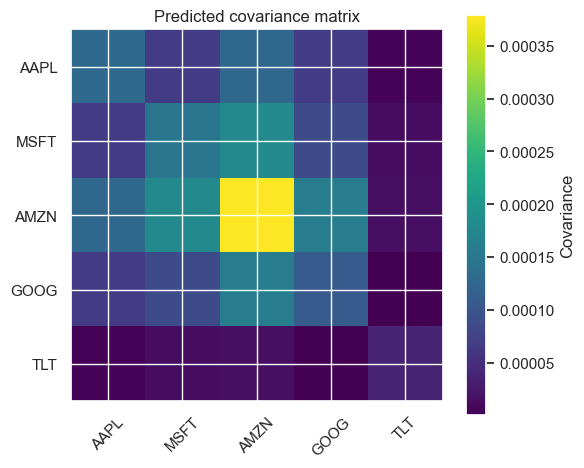

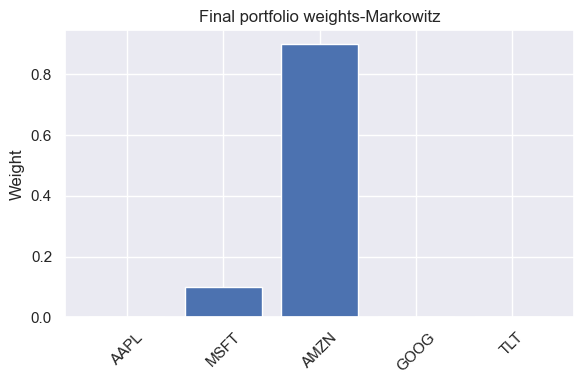

Final portfolio statistics
---------------------------
Expected return : 0.0033
Volatility      : 0.0184
Sharpe ratio    : 0.1778


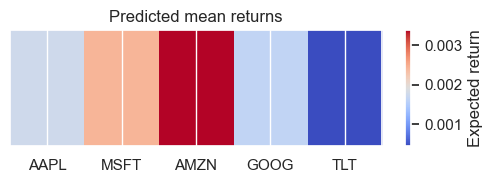

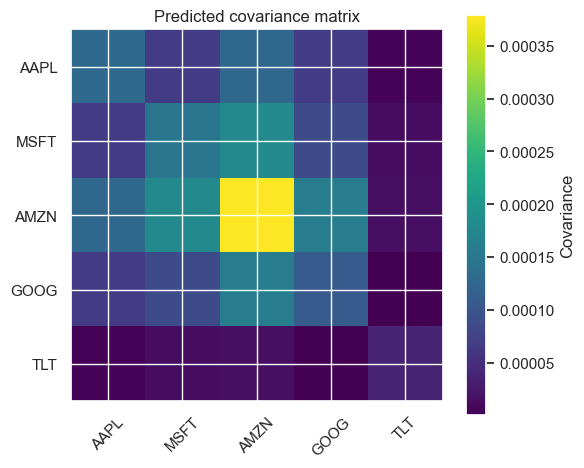

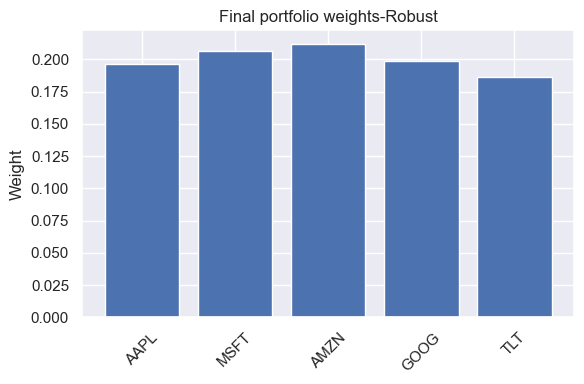

Final portfolio statistics
---------------------------
Expected return : 0.0020
Volatility      : 0.0097
Sharpe ratio    : 0.2034


In [17]:
visualize_single_portfolio(
    mu=mu_hat,
    Sigma=Sigma_hat,
    w=results["weights"][-1],
    tickers=tickers,
    title_suffix="-EqualWeight"
)

visualize_single_portfolio(
    mu=mu_hat,
    Sigma=Sigma_hat,
    w=results_markowitz["weights"][-1],
    tickers=tickers,
    title_suffix="-Markowitz"
)
visualize_single_portfolio(
    mu=mu_hat,
    Sigma=Sigma_hat,
    w=results_robust["weights"][-1],
    tickers=tickers,
    title_suffix="-Robust"
)


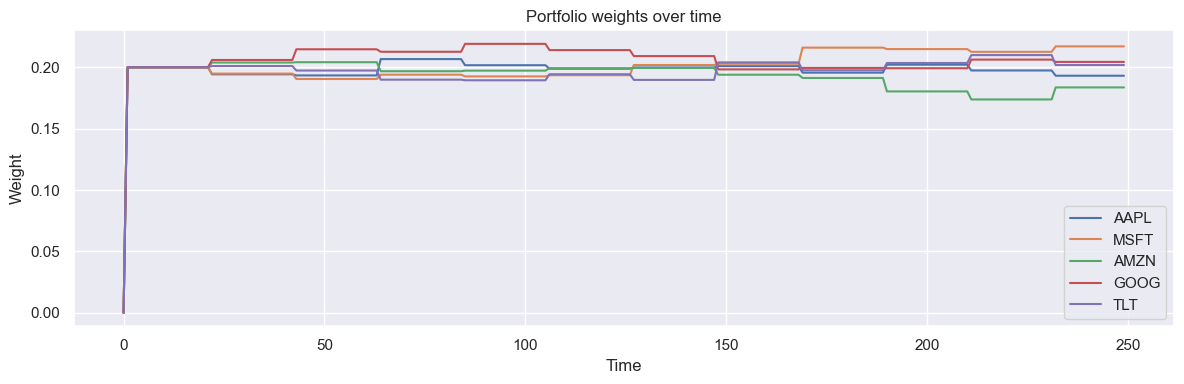

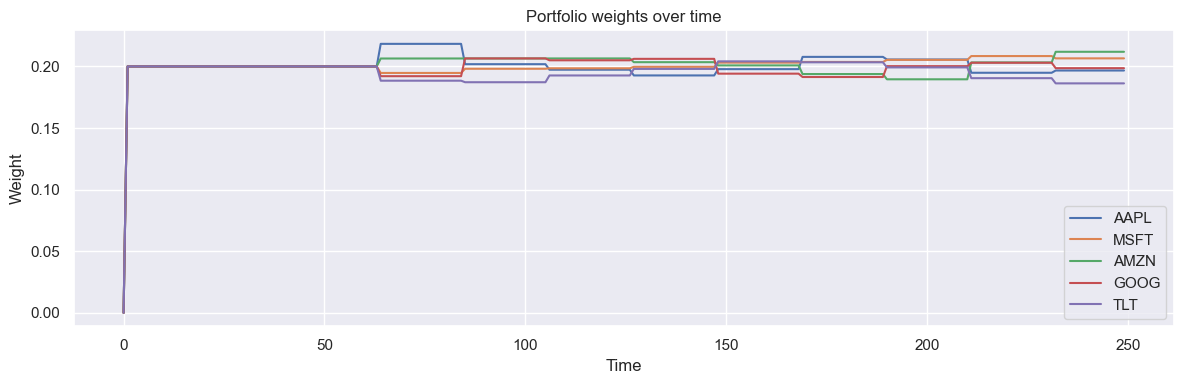

In [22]:
plot_weights_over_time(results["weights"], tickers)
plot_weights_over_time(results_robust["weights"], tickers)

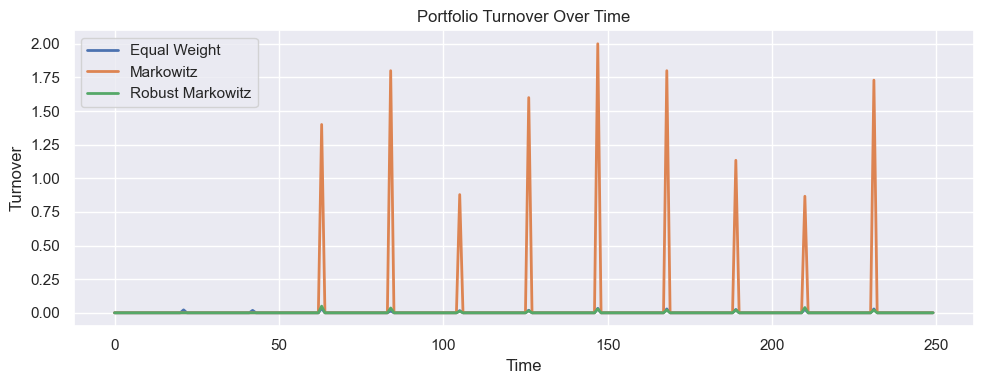

In [23]:
plt.figure(figsize=(10,4))

plt.plot(results["turnover"], label="Equal Weight", linewidth=2)
plt.plot(results_markowitz["turnover"], label="Markowitz", linewidth=2)
plt.plot(results_robust["turnover"], label="Robust Markowitz", linewidth=2)

plt.title("Portfolio Turnover Over Time")
plt.xlabel("Time")
plt.ylabel("Turnover")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


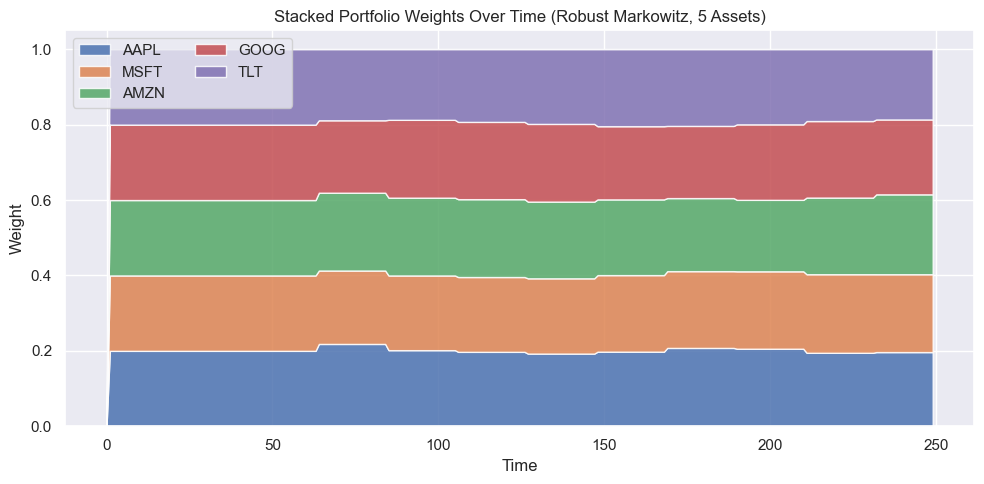

In [24]:
selected_tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]
ticker_idx = [tickers.index(t) for t in selected_tickers]

weights = results_robust["weights"][:, ticker_idx]

plt.figure(figsize=(10,5))

plt.stackplot(
    range(weights.shape[0]),
    weights.T,
    labels=selected_tickers,
    alpha=0.85
)

plt.title("Stacked Portfolio Weights Over Time (Robust Markowitz, 5 Assets)")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()